In [1]:
import os

# For fast CPU-only startup 
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import time
from ML4transients.data_access import DatasetLoader
from ML4transients.training import PytorchDataset
import pandas as pd
import numpy as np

print("Loading dataset...")
t0 = time.time()
dataset = DatasetLoader('/sps/lsst/groups/transients/HSC/fouchez/raphael/data/rc2_coadd')
print(f"Dataset loaded in {time.time() - t0:.2f} seconds")


2025-11-07 14:20:46.939123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762521646.959839 4025368 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762521646.966065 4025368 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762521646.982989 4025368 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762521646.983005 4025368 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762521646.983007 4025368 computation_placer.cc:177] computation placer alr

Loading dataset...
Dataset loaded in 0.01 seconds


In [8]:
a=dataset.get_dataset_statistics()
a=dataset2.get_dataset_statistics()

Computing dataset statistics...

DATASET STATISTICS SUMMARY

Data Overview:
  Total visits: 40
  Data paths: 1
  Visits with cutouts: 40
  Visits with features: 40

Cutout Statistics:
  Total cutouts: 57,903
  Average per visit: 1447.6

Feature Statistics:
  Total features: 57,903
  Average per visit: 1447.6

Label Distribution:
  Total labeled sources: 57,903
  Injections: 13,118 (22.7%)
  Real sources: 44,785 (77.3%)

Inference Results:
  Inference files: 0
  Models used: 0
  Visits with inference: 0

Computing dataset statistics...

DATASET STATISTICS SUMMARY

Data Overview:
  Total visits: 40
  Data paths: 1
  Visits with cutouts: 40
  Visits with features: 40

Cutout Statistics:
  Total cutouts: 57,905
  Average per visit: 1447.6

Feature Statistics:
  Total features: 57,905
  Average per visit: 1447.6

Label Distribution:
  Total labeled sources: 57,905
  Injections: 13,118 (22.7%)
  Real sources: 44,787 (77.3%)

Inference Results:
  Inference files: 79
  Models used: 2
  Visits 

# Cutouts


Discovering data files...
Data discovery completed in 0.00s: 40 cutout visits, 40 feature visits, 0 lightcurve paths
Loading cutouts from visit 322


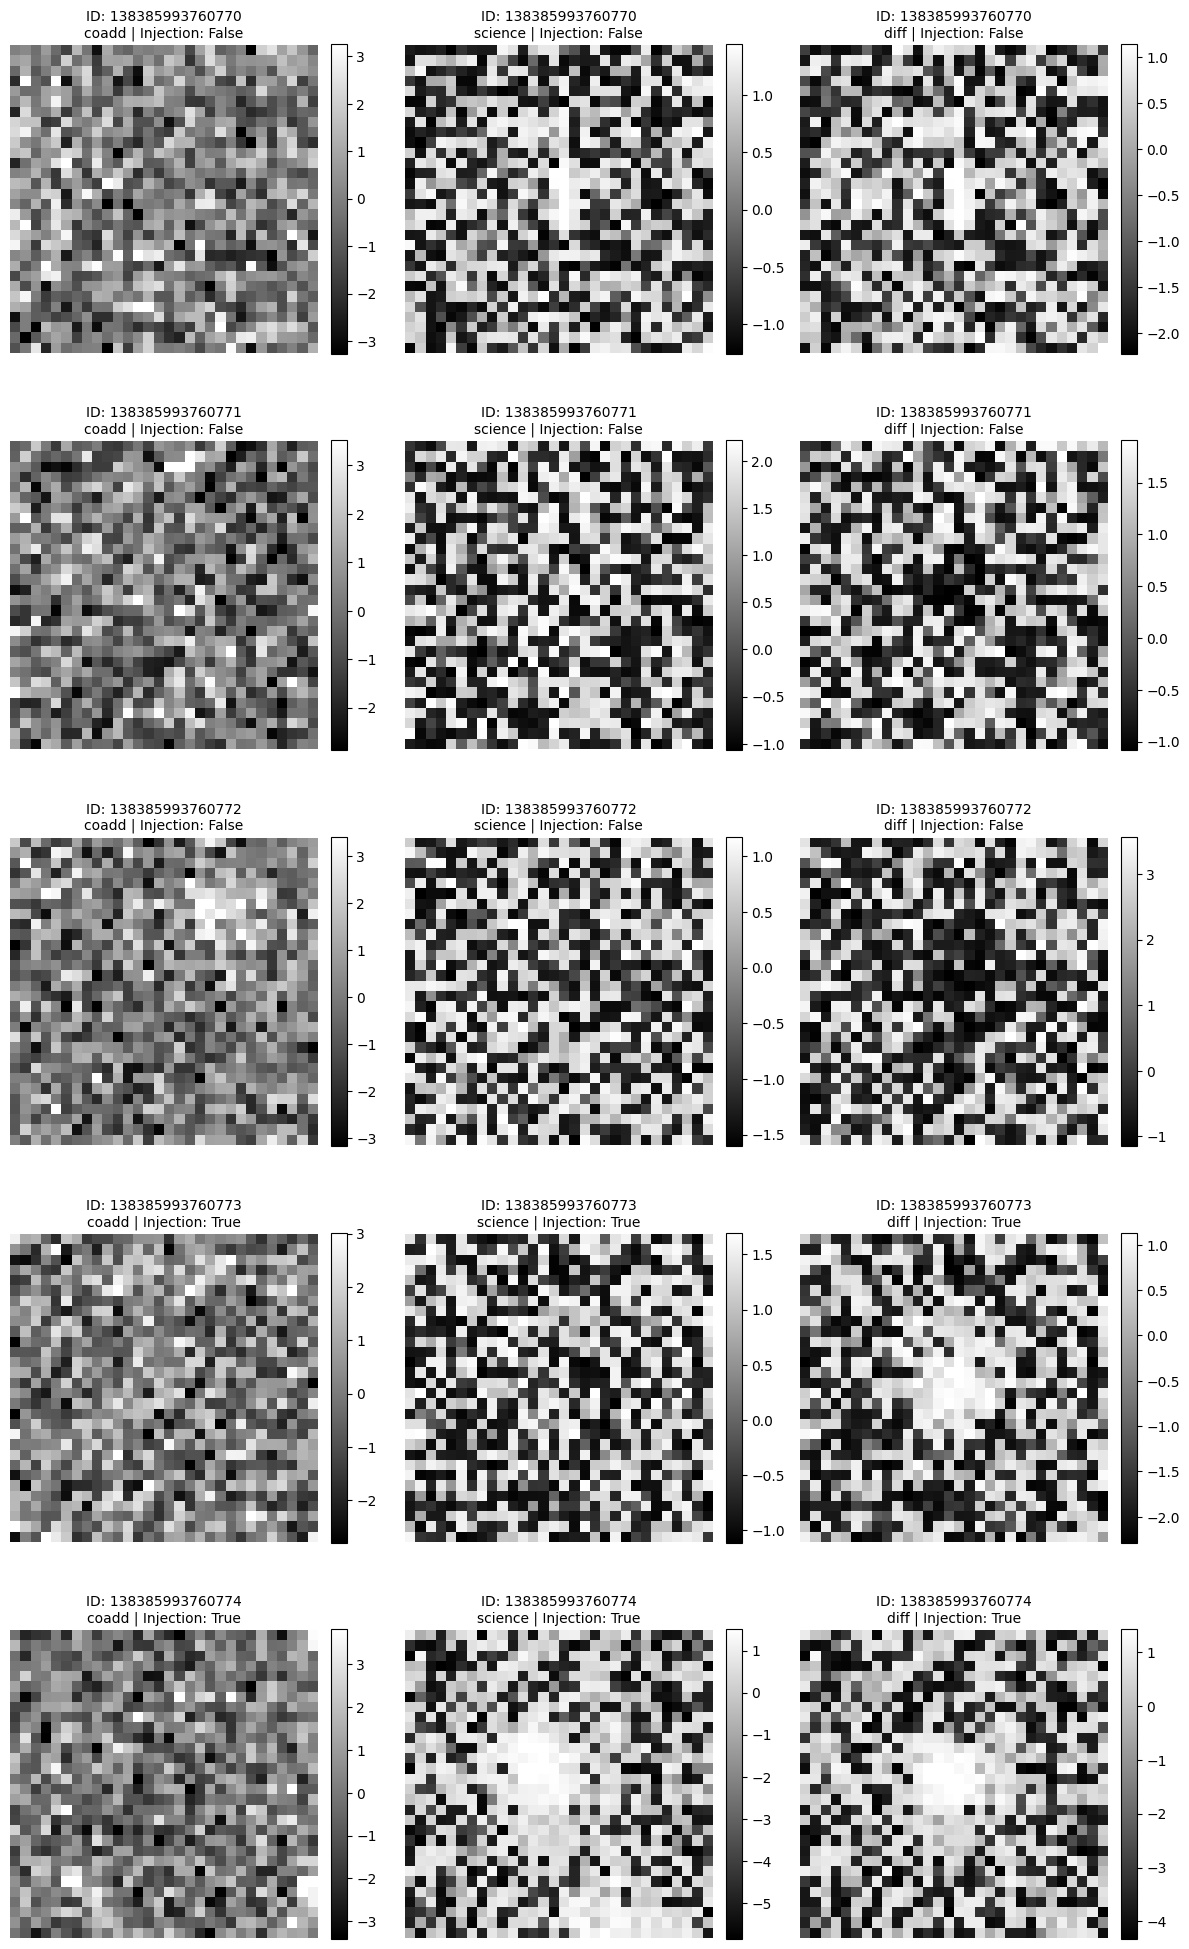

Cutout shape: (30, 30)
Value range: [-4.328, 1.425]


In [4]:
import matplotlib.pyplot as plt

first_visit = dataset.visits[0]
print(f"Loading cutouts from visit {first_visit}")

cutout_loader = dataset.cutouts[first_visit]
feature_loader = dataset.features[first_visit]
sample_ids = cutout_loader.ids[:5]  # show two DIA IDs

cutout_types = ['coadd','science', 'diff']

# rows = number of samples, columns = number of cutout types
n_rows = len(sample_ids)
n_cols = len(cutout_types)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))

for row_idx, dia_id in enumerate(sample_ids):
    features = feature_loader.get_by_id(dia_id)
    is_injection = features['is_injection'].iloc[0] if not features.empty else False

    for col_idx, cutout_type in enumerate(cutout_types):
        ax = axes[row_idx, col_idx] if n_rows > 1 else axes[col_idx]

        # Load cutout of a specific type
        cutout = cutout_loader.get_by_id(dia_id, cutout_type=cutout_type)

        im = ax.imshow(cutout, cmap='gray', origin='lower')
        ax.set_title(f'ID: {dia_id}\n{cutout_type} | Injection: {is_injection}', fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Optional diagnostics for one example
print(f"Cutout shape: {cutout.shape}")
print(f"Value range: [{cutout.min():.3f}, {cutout.max():.3f}]")


# LC visualization

In [ ]:
dataset.lightcurves.plot_lightcurve(dia_object_id=3495914812699862335)

In [ ]:
data_path = dataset.data_paths[0]
diasource_index_file = data_path / "lightcurves" / "diasource_patch_index.h5"
data_path

In [ ]:
diasource_index = pd.read_hdf(diasource_index_file, key='diasource_index')


In [ ]:
dia_object_id=3495901618560337471
sources_for_object = diasource_index[diasource_index['diaObjectId'] == dia_object_id]
len(sources_for_object)
sources_for_object

In [ ]:
sources_for_object.columns

In [ ]:
def plot_lc_cutout(dia_object_id, cutout_type="diff"): 
    sources_for_object = diasource_index[diasource_index['diaObjectId'] == dia_object_id]
    len(sources_for_object)
    sources_for_object
    # number of sources
    n = len(sources_for_object.index)
    if n>20: 
        print("too long")
        return 0
    # create subplots (1 row, n columns)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))  # adjust figsize as needed

    # ensure axes is iterable even if n=1
    if n == 1:
        axes = [axes]

    for ax, i in zip(axes, sources_for_object.index):
        img = dataset.get_cutout_by_id(i, cutout_type=cutout_type)
        ax.imshow(img)
        ax.axis('off')  # optional, hide axes
        ax.set_title(str(i))  # optional, label each cutout

    plt.tight_layout()
    plt.show()

In [ ]:
id=3496002773630107900
plot_lc_cutout(id, 'coadd')
plot_lc_cutout(id, 'science')
plot_lc_cutout(id, 'diff')

In [ ]:
plot_lc_cutout(sources_for_object, 'coadd')

In [ ]:
import matplotlib.pyplot as plt
for i in sources_for_object.index:
    plt.imshow(dataset.get_cutout_by_id(i, cutout_type='science'))
    plt.show()

# Lc inference

In [ ]:
r = dataset.lightcurves.inference_snn

In [ ]:
high_conf = list(dataset.lightcurves.get_high_conf_sn_sources(prob_threshold=0.5, std_threshold=0.1))

diasource_index = dataset.lightcurves.diasource_index
# This will get the unique diaObjectIds corresponding to your high-confidence sources
high_conf_obj_ids = list(set(diasource_index.loc[
    diasource_index.index.isin(high_conf), 'diaObjectId'
]))

stats_dict = dataset.lightcurves.summarize_multiple_lightcurves(high_conf_obj_ids)
print(stats_dict)

In [ ]:
high_conf = list(dataset.lightcurves.get_high_conf_sn_sources(prob_threshold=0.5, std_threshold=0.3))

diasource_index = dataset.lightcurves.diasource_index
# This will get the unique diaObjectIds corresponding to your high-confidence sources
high_conf_obj_ids = list(set(diasource_index.loc[
    diasource_index.index.isin(high_conf), 'diaObjectId'
]))

stats_dict = dataset.lightcurves.summarize_multiple_lightcurves(high_conf_obj_ids)
print(stats_dict)

In [ ]:
dataset.lightcurves.save_high_conf_subset_dataset("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_coadd_SNN", prob_threshold=0.5, std_threshold=0.3)

# Cross matching


## High conf


In [ ]:
small_ds = DatasetLoader("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_coadd_SNN")
small_ds._discover_data()

In [ ]:
small_ds = DatasetLoader("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_coadd_SNN")
nogaia = small_ds.filter_by_crossmatch('source_cat_gaia', matched=True)
small_ds = DatasetLoader("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_coadd_SNN")
agn = small_ds.filter_by_crossmatch('milliquas_filtered', matched=True)

In [ ]:
for i in nogaia:
    print(i)

In [ ]:
for i in agn:
    print(i)

## Udeep

In [ ]:
gaia_stars = dataset.filter_by_crossmatch('source_cat_gaia', matched=True)
transient_candidates = dataset.filter_by_crossmatch('source_cat_gaia', matched=False)

In [ ]:
for i in gaia_stars:
    print(i)